In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import numpy as np

In [3]:
date_str = "20240701"
global_FLCI = xr.open_dataarray("composite/global/global_"+date_str+".nc")

In [4]:
global_FLCI

<xarray.DataArray 'BTD' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

In [5]:
lons = global_FLCI.longitude-180

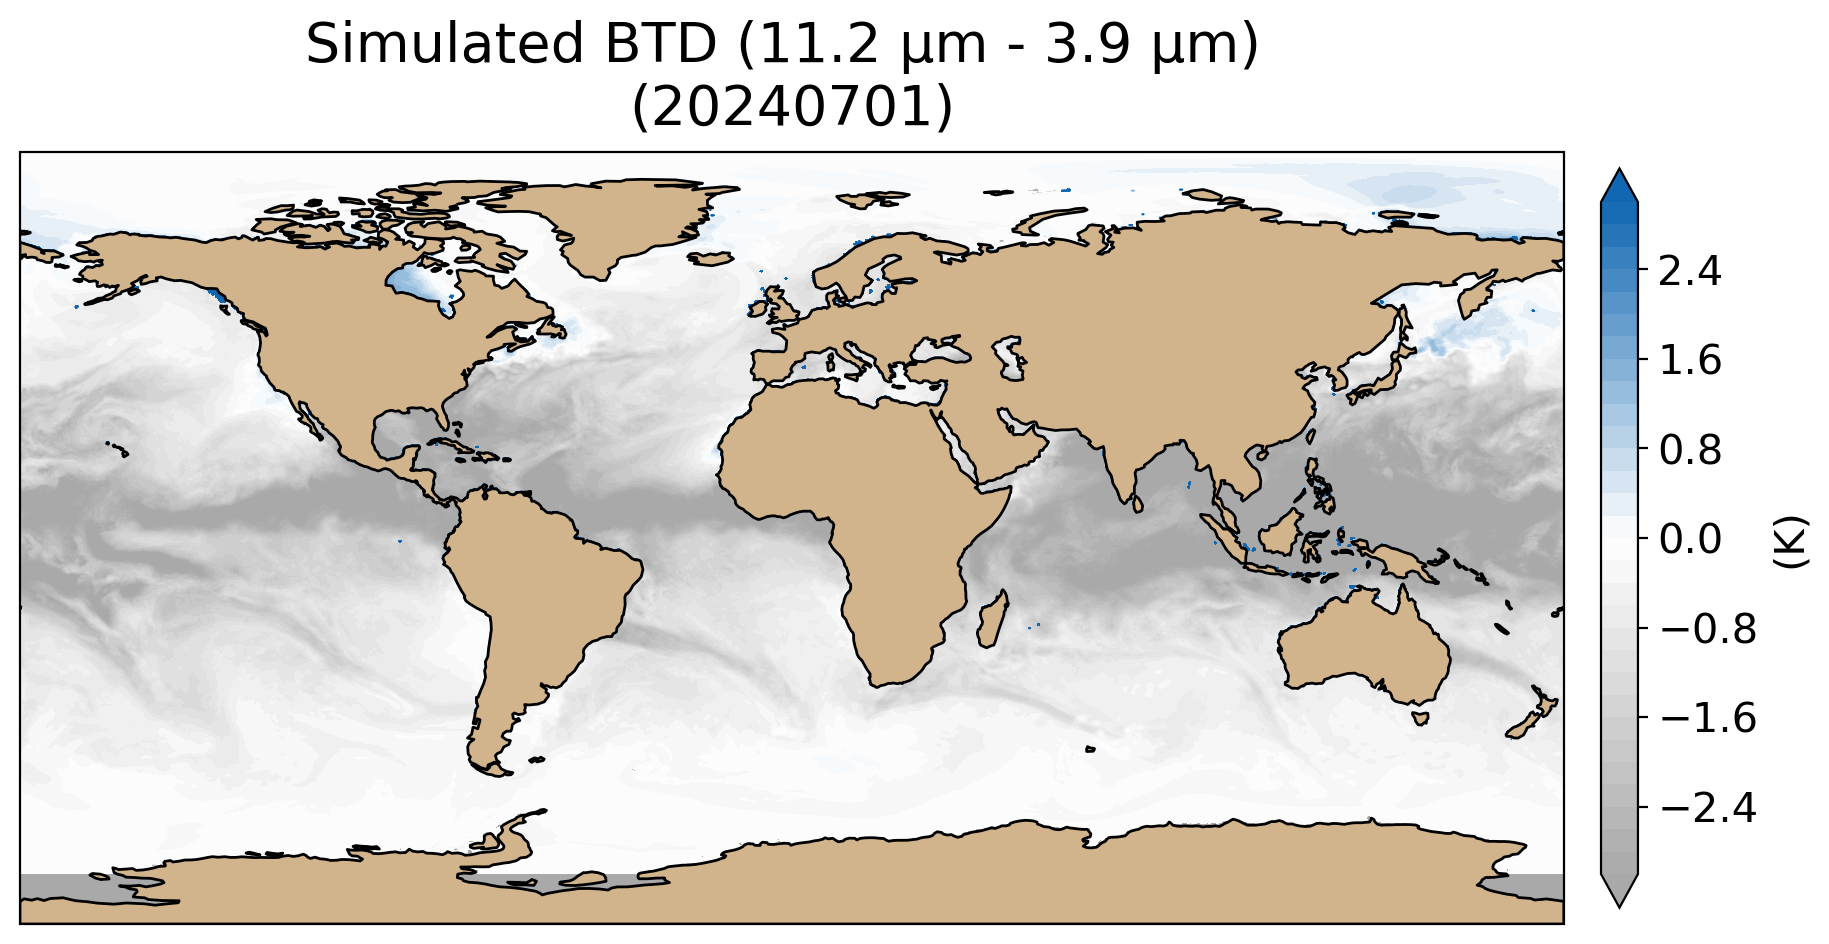

In [6]:
BTD = global_FLCI

projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---Custom colorbar
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, '#A9A9A9'), (0.5, 'white'), (1, '#1167b1')]  # +3 = blueish teal, 0 = white, -3 = grey
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


#---Local max and min, taking into account the zeroes from the NAN region (land)
max_BTD = BTD.where(BTD > -20).max().item()
min_BTD = BTD.where(BTD > -20).min().item()

#---Setting the colorbar levels
levels = np.linspace(-3, 3, 31)

#---Plotting
c=ax.contourf(global_FLCI.longitude, global_FLCI.latitude, BTD, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n("+date_str+")", fontsize=20, pad=10)

#--- Land in tan
ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='tan')

#---- Land in black
#ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#000')

#--- Removed temporarily to speed up
fig.set_dpi(200)